In [1]:

%reset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

'''
Hyper-parameters Settings
'''
HAMPEL_WINDOW_SIZE = 21
HAMPEL_THRESHOLD = 1
HAMPEL_IMPUTATION = True

'''
Path Settings
'''
CONFIGURATION_FILE_PATH = "./data/train/data_config.csv"
DATASET_PATH = "./data/train/"

'''
Program Configurations
'''
COP_OUTPUT_SAVE_IMAGE = False
COP_OUTPUT_SAVE_CSV = True
LOADCELL_OUTPUT_SAVE_IMAGE = False
LOADCELL_OUTPUT_SAVE_CSV = True
FSR_SCALEUP_OUTPUT_SAVE_IMAGE = True
FSR_SCALEUP_COMPARE_SAVE_IMAGE = False
FSR_REGION_CROP_ENABLE = True
DYNAMIC_FSR_SCALEUP = True


'''
Figure Settings
'''
pd.set_option('display.width', 200) # for display width


'''
1. Read Configurration File (only xls)
'''
data_config = pd.read_csv(CONFIGURATION_FILE_PATH, header=0, index_col=0)
print("Configuration Dataframe dimension: ", data_config.shape)


'''
2. Read all FSR matrix data and Seat sensor data
'''
fsr_dataframe = {}
seat_dataframe = {}

for idx in data_config.index:
    fsr_filepath = DATASET_PATH+data_config.loc[idx, "fsr_matrix_1d_datafile"] # set FSR matrix data filepath
    seat_filepath = DATASET_PATH+data_config.loc[idx, "seat_datafile"] # set Seat data filepath
    print(idx, ") read data files : ", fsr_filepath, ",", seat_filepath)

    fsr_dataframe[idx] = pd.read_csv(fsr_filepath, header=0, index_col=False).iloc[:,0:162] # read FSR matrix data file
    seat_dataframe[idx] = pd.read_csv(seat_filepath, header=0, index_col=False) # read Seat data file

    # clear unnecessary columns
    del seat_dataframe[idx]['Measurement time'] # remove unnecessary column
    del fsr_dataframe[idx]['Measurement Time (sec)'] # remove unnecessary column
print("done.")


Nothing done.
Configuration Dataframe dimension:  (49, 12)
1 ) read data files :  ./data/train/20210303T160024-1dm.csv , ./data/train/data_01m.csv
2 ) read data files :  ./data/train/20210310T104529-1dm.csv , ./data/train/data_02m.csv
3 ) read data files :  ./data/train/20210310T110616-1dm.csv , ./data/train/data_03m.csv
4 ) read data files :  ./data/train/20210318T170103-1dm.csv , ./data/train/data_04m.csv
5 ) read data files :  ./data/train/20210310T153307-1dm.csv , ./data/train/data_05m.csv
6 ) read data files :  ./data/train/20210310T154900-1dm.csv , ./data/train/data_06m.csv
7 ) read data files :  ./data/train/20210311T131751-1dm.csv , ./data/train/data_07m.csv
8 ) read data files :  ./data/train/20210311T134516-1dm.csv , ./data/train/data_08m.csv
9 ) read data files :  ./data/train/20210311T150952-1dm.csv , ./data/train/data_09m.csv
10 ) read data files :  ./data/train/20210311T153746-1dm.csv , ./data/train/data_10m.csv
11 ) read data files :  ./data/train/20210311T154809-1dm.csv

In [3]:
'''
7. Model Training
@brief  Multiclass Classification using LSTM with keras
'''
import random

# class separation (positive, negative)
shuffled_index = np.array(data_config.index)
random.shuffle(shuffled_index)
positive_class = shuffled_index[0:4] # first 5 index select from shuffled_index
negative_class = shuffled_index[5:]
negative_class_zero = np.zeros(len(negative_class), dtype=int)
classes = np.append(positive_class, 0)

print(classes)

[40 24 44  3  9  0]


In [6]:
'''
7. Model Training
@brief  Multiclass Classification using LSTM with keras
'''
import random


# 1. input image transfer into the convolution network
# - convnet is created and time distributed to detect features
# - the time distributed output is injected to GRU or LSTM to treat "time series"
# - a densenet is the applied to take the decision, to classify
# convnet : for feature extraction, densenet : for decision making

from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
import keras
import numpy as np
from keras_video import VideoFrameGenerator
import glob
import os

# user parameters
SIZE = (68, 217) # crop image
CHANNELS = 3 # image channels
NBFRAME = 10 # near frames
BS = 5 #batch size
KERNEL_SIZE = (10,10)
EPOCHS=50

def build_convnet(shape=(SIZE, CHANNELS)):
    momentum = 0.9
    model = keras.Sequential()
    model.add(Conv2D(64, KERNEL_SIZE, input_shape=shape, padding='same', activation='relu')) # shape = (row, col, channels)
    model.add(Conv2D(64, KERNEL_SIZE, padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())

    model.add(Conv2D(128, KERNEL_SIZE, padding='same', activation='relu'))
    model.add(Conv2D(128, KERNEL_SIZE, padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())

    model.add(Conv2D(256, KERNEL_SIZE, padding='same', activation='relu'))
    model.add(Conv2D(256, KERNEL_SIZE, padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())

    model.add(Conv2D(512, KERNEL_SIZE, padding='same', activation='relu'))
    model.add(Conv2D(512, KERNEL_SIZE, padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPool2D())

    # flatten
    model.add(GlobalMaxPool2D())
    return model

from keras.layers import TimeDistributed, GRU, Dense, Dropout, LSTM

def action_model(shape=(SIZE, CHANNELS), nbout=5):
    #create convnet with (112, 112, 1) input shape
    convnet = build_convnet(shape[1:])

    #then create out final model
    model = keras.Sequential()

    # add the convnet with (5, 112, 112, 3) shape
    model.add(TimeDistributed(convnet, input_shape=shape))

    # you can also use GRU or LSTM
    model.add(GRU(5))

    # finally we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nbout, activation='softmax'))

    return model

# use sub directories names as classes
classes = [i.split(os.path.sep)[1] for i in glob.glob('train/*')]
classes.sort()

# model compile
INSHAPE=(NBFRAME,) + SIZE + (CHANNELS,)
print(INSHAPE)
model = action_model(INSHAPE, len(classes))
optimizer = keras.optimizers.Adam(0.001)
#optimizer = keras.optimizers.SGD(lr=0.01)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['acc']
)

print("model was compiled")

# pattern to get videos and classes
glob_pattern='train/{classname}/standard_*.avi'
# for data augmentation
# data_aug = keras.preprocessing.image.ImageDataGenerator(
#     zoom_range=.1,
#     horizontal_flip=False,
#     rotation_range=8,
#     width_shift_range=.2,
#     height_shift_range=.2)

# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=.2, 
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    #transformation=data_aug,
    use_frame_cache=False)


valid = train.get_validation_generator()
print(valid)

# create a "chkp" directory before to run that
# because ModelCheckpoint will write models inside
callbacks = [
    keras.callbacks.ReduceLROnPlateau(verbose=1),
    keras.callbacks.ModelCheckpoint(
        'chkp/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
        verbose=1),
]

history = model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)



(10, 68, 217, 3)
model was compiled
class 1, validation count: 1, train count: 4
class 2, validation count: 1, train count: 4
class 3, validation count: 1, train count: 4
class 4, validation count: 1, train count: 4
class 5, validation count: 1, train count: 4
Total data: 5 classes for 20 files for train
Total data: 5 classes for 5 files for validation
Epoch 1/50
4/4 [==============================] - 132s 34s/step - loss: 1.5712 - acc: 0.3267 - val_loss: 1.6128 - val_acc: 0.2000

Epoch 00001: saving model to chkp/weights.01-1.61.hdf5
Epoch 2/50
4/4 [==============================] - 132s 34s/step - loss: 1.5922 - acc: 0.1933 - val_loss: 1.6202 - val_acc: 0.2000

Epoch 00002: saving model to chkp/weights.02-1.62.hdf5
Epoch 3/50
4/4 [==============================] - 134s 34s/step - loss: 1.5582 - acc: 0.2533 - val_loss: 1.6218 - val_acc: 0.2000

Epoch 00003: saving model to chkp/weights.03-1.62.hdf5
Epoch 4/50
4/4 [==============================] - 133s 34s/step - loss: 1.6735 - acc: 0

KeyboardInterrupt: 

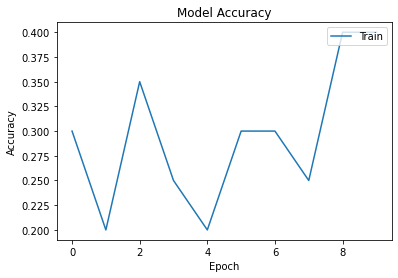

{'loss': [1.5945587158203125, 1.7196605205535889, 1.58034348487854, 1.6132675409317017, 1.6417983770370483, 1.567399263381958, 1.5181326866149902, 1.553778886795044, 1.4166629314422607, 1.3338590860366821], 'acc': [0.30000001192092896, 0.20000000298023224, 0.3499999940395355, 0.25, 0.20000000298023224, 0.30000001192092896, 0.30000001192092896, 0.25, 0.4000000059604645, 0.4000000059604645], 'val_loss': [1.6087299585342407, 1.6045690774917603, 1.6130778789520264, 1.627518653869629, 1.6111621856689453, 1.6143125295639038, 1.6174004077911377, 1.621874213218689, 1.6207348108291626, 1.6105244159698486], 'val_acc': [0.20000000298023224, 0.20000000298023224, 0.4000000059604645, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224, 0.20000000298023224], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}


In [5]:
'''
accuracy plot
'''
import matplotlib.pyplot as plt

plt.plot(history.history["acc"])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(['Train'], loc='upper right')
plt.show()

print(history.history)